In [1]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.metrics import accuracy_score
import pytensor.tensor as pt

scaler = StandardScaler()
print(f'PyMC version: {pm.__version__}')

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


PyMC version: 5.0.2


In [2]:
X_1 = pd.read_csv('../../data_fake/features_4_2/hr/2.csv')
X_2 = pd.read_csv('../../data_fake/features_4_2/eda/2.csv')
# prova con normalizzazione
# X = scaler.fit_transform(X)
X1_train = X_1[:120].to_numpy()
N_train = X1_train.shape[0]
D1 = X1_train.shape[1]
D1

24

In [3]:
df_ = pd.read_csv('../../data/LookAtMe_002.csv', sep='\t')
expectancy_label = np.array(list([int(d > 2) for d in df_['rating']]))[:, np.newaxis]
exp_train = expectancy_label[:120]
D2 = exp_train.shape[1]
D2

1

In [4]:
def expand_packed_block_triangular(d, k, packed, diag=None, mtype="pytensor"):
    # like expand_packed_triangular, but with d > k.
    assert mtype in {"pytensor", "numpy"}
    assert d >= k

    def set_(M, i_, v_):
        if mtype == "pytensor":
            return pt.set_subtensor(M[i_], v_)
        M[i_] = v_
        return M

    out = pt.zeros((d, k), dtype=float) if mtype == "pytensor" else np.zeros((d, k), dtype=float)
    if diag is None:
        idxs = np.tril_indices(d, m=k)
        out = set_(out, idxs, packed)
    else:
        idxs = np.tril_indices(d, k=-1, m=k)
        out = set_(out, idxs, packed)
        idxs = (np.arange(k), np.arange(k))
        out = set_(out, idxs, diag)
    return out


def makeW(d, k, dim_names, name):
    # make a W matrix adapted to the data shape
    n_od = int(k * d - k * (k - 1) / 2 - k)
    # trick: the cumulative sum of z will be positive increasing
    z = pm.HalfNormal("W_z_" + name, 1.0, dims="latent_columns")
    b = pm.HalfNormal("W_b_" + name, 1.0, shape=(n_od,), dims="packed_dim")
    L = expand_packed_block_triangular(d, k, b, pt.ones(k))
    W = pm.Deterministic(name, pt.dot(L, pt.diag(pt.extra_ops.cumsum(z))), dims=dim_names)
    return W

In [5]:
k = 2
# model definition
with pm.Model() as PPCA_identified:
        PPCA_identified.add_coord("latent_columns", np.arange(k), mutable=True)
        PPCA_identified.add_coord("rows", np.arange(N_train), mutable=True)
        PPCA_identified.add_coord("observed_hr", np.arange(D1), mutable=False)
        PPCA_identified.add_coord("observed_label", np.arange(D2), mutable=False)

        hr_data = pm.MutableData("hr_data", X1_train.T, dims=["observed_hr", "rows"])

        W_hr = makeW(D1, k, ("observed_hr", "latent_columns"), 'W_hr')

        W_e = pm.Normal("W_e", dims=["observed_label", "latent_columns"])
        C = pm.Normal("C", dims=["latent_columns", "rows"])


        psi_hr = pm.HalfNormal("psi_hr", 1.0)
        X_hr = pm.Normal("X_hr", mu=pt.dot(W_hr, C), sigma=psi_hr, observed=hr_data, dims=["observed_hr", "rows"])


        X_e = pm.Bernoulli("X_e", p=pm.math.sigmoid(pt.dot(W_e, C)), dims=["observed_label", "rows"],
                           observed=exp_train.T)

In [6]:
with PPCA_identified:
    approx = pm.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])
    trace = approx.sample(1000)


Finished [100%]: Average Loss = 27,852


In [7]:
with PPCA_identified:
    PPCA_identified.set_data('hr_data', X1_train.T, coords={'rows': range(X1_train.shape[0])})
    posterior_predictive = pm.sample_posterior_predictive(
        trace, random_seed=123)

e_pred_train = posterior_predictive.posterior_predictive['X_e']
e_pred_mode_train = np.squeeze(stats.mode(e_pred_train[0], keepdims=False)[0])[:, np.newaxis]


Sampling: [X_e, X_hr]


In [8]:
train_accuracy_exp = accuracy_score(exp_train, e_pred_mode_train)
print(train_accuracy_exp)

0.9833333333333333


In [9]:
latent_space = pd.DataFrame()
latent_space['X'] = np.array(C.eval()[0])
latent_space['Y'] = np.array(C.eval()[1])
latent_space['label'] = e_pred_mode_train
latent_space

,X,Y,label
0,1.996682,-1.258417,1
1,1.123699,-0.067307,1
2,2.171738,0.888277,1
3,-0.224595,-0.856888,1
4,-0.598044,1.377826,1
...,...,...,...
115,0.183236,0.571333,1
116,-0.075263,-0.459901,0
117,0.239067,0.180773,1
118,-0.070861,1.375906,1


## scatter plot latent space

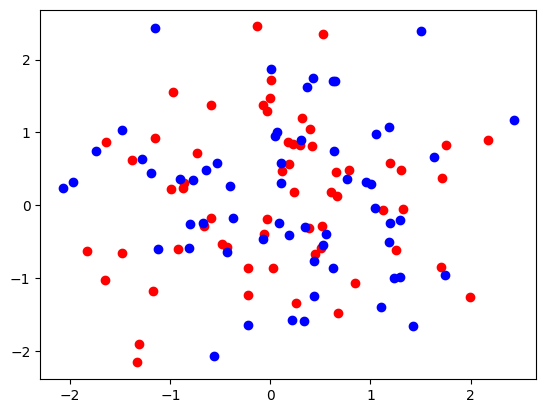

In [10]:
plt.scatter(latent_space[latent_space['label'] == 1].X, latent_space[latent_space['label'] == 1].Y, color = 'r')
plt.scatter(latent_space[latent_space['label'] == 0].X, latent_space[latent_space['label'] == 0].Y, color = 'b')
plt.show()

In [21]:
X1_test = X_1[120:]
exp_test = expectancy_label[120:]
print(X1_test.shape)
print(exp_test.shape)

(40, 24)
(40, 1)


In [38]:
with PPCA_identified:
    # update values of predictors with validation:
    PPCA_identified.set_data(name="hr_data", values=X1_test.T, coords={'rows': range(X1_test.shape[0])})
    posterior_predictive = pm.sample_posterior_predictive(
        trace, random_seed=123, predictions=True)

e_pred = posterior_predictive.predictions['X_e']
e_pred_test = np.squeeze(stats.mode(e_pred[0], keepdims=False)[0])[:, np.newaxis]
test_accuracy_exp = accuracy_score(exp_test, e_pred_test)
print(test_accuracy_exp)

Sampling: [C, X_e, X_hr]


0.6
